In [1]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.616940,0.850000,0.902439,0.770833,0.831461
2,0.443700,0.596184,0.850000,0.843750,0.843750,0.843750
3,0.443700,0.670730,0.865000,0.863158,0.854167,0.858639


Overall Accuracy: 1.0000
Overall Precision: 1.0000
Overall Recall: 1.0000
Overall F1 Score: 1.0000


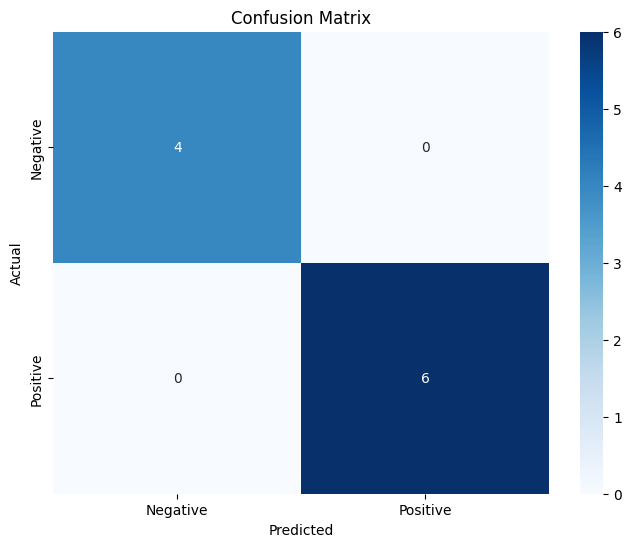

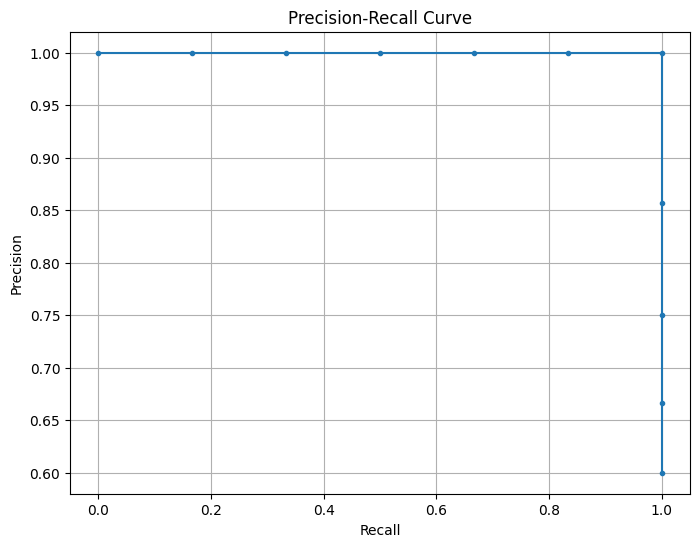

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


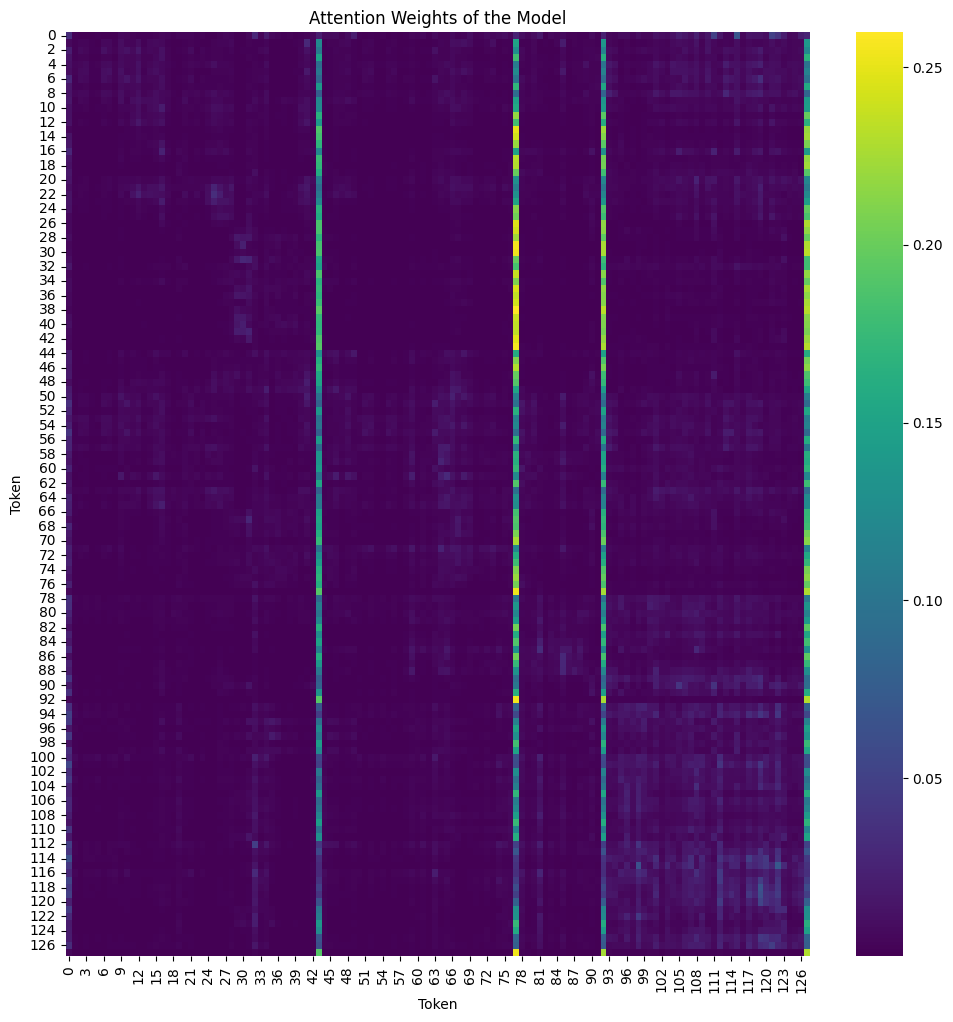

Sentence: <br /><br />When I unsuspectedly rented A Thousand Acres, I thought I was in for an entertaining King Lear story and of course Michelle Pfeiffer was in it, so what could go wrong?<br /><br />Very quickly, however, I realized that this story was about A Thousand Other Things besides just Acres. I started crying and couldn't stop until long after the movie ended. Thank you Jane, Laura and Jocelyn, for bringing us such a wonderfully subtle and compassionate movie! Thank you cast, for being involved and portraying the characters with such depth and gentleness!<br /><br />I recognized the Angry sister; the Runaway sister and the sister in Denial. I recognized the Abusive Husband and why he was there and then the Father, oh oh the Father... all superbly played. I also recognized myself and this movie was an eye-opener, a relief, a chance to face my OWN truth and finally doing something about it. I truly hope A Thousand Acres has had the same effect on some others out there.<br /><b

In [2]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datasets import load_dataset

# Initialize model and tokenizer
def initialize_model_and_tokenizer(model_name='bert-base-uncased'):
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
    return model, tokenizer

# Load dataset from Hugging Face
def load_and_prepare_dataset():
    dataset = load_dataset('imdb')
    # We use a smaller subset for quicker demonstration
    train_data = dataset['train'].shuffle(seed=42).select(range(1000))
    val_data = dataset['test'].shuffle(seed=42).select(range(200))
    return train_data, val_data

# Tokenization and encoding function
def encode_data(texts, targets, tokenizer):
    encoded = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
    encoded['labels'] = torch.tensor(targets)
    return encoded

# Custom Dataset class for PyTorch
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encoded_data):
        self.data = encoded_data
        self.labels = encoded_data['labels']

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.data.items() if key != 'labels'}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Define compute_metrics function for evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    predictions = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary', zero_division=0)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Training function using Trainer API
def train_and_save_model(model, tokenizer, train_dataset, val_dataset):
    training_args = TrainingArguments(
        output_dir='./training_results',
        evaluation_strategy='epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        num_train_epochs=3,
        weight_decay=0.01,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()
    model.save_pretrained('sentiment_classifier')
    tokenizer.save_pretrained('sentiment_classifier')
    return trainer

# Plot training and validation loss curves
def plot_training_curves(trainer):
    logs = trainer.state.log_history

    # Extract loss values and epochs
    epochs = [log['epoch'] for log in logs if 'epoch' in log]
    train_loss = [log['loss'] for log in logs if 'loss' in log]
    eval_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log]

    # Ensure that there are values for both train_loss and eval_loss
    if len(train_loss) == 0 or len(epochs) == 0:
        print("No training loss values found.")
        return

    # Plot training and validation loss curves
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_loss, label='Training Loss', marker='o')
    if eval_loss:
        plt.plot(epochs[:len(eval_loss)], eval_loss, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(preds, labels):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Plot examples of correct and incorrect predictions
def plot_examples(model, tokenizer, texts, true_labels):
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    fig, ax = plt.subplots(len(texts), 1, figsize=(10, 20))
    for i, (text, true_label) in enumerate(zip(texts, true_labels)):
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            predicted_label = torch.argmax(outputs.logits, dim=1).item()

        ax[i].bar(['True Label', 'Predicted Label'], [true_label, predicted_label], color=['blue', 'red'])
        ax[i].set_title(f'Text: {text}')
        ax[i].set_ylim(0, 1)
        ax[i].set_ylabel('Label')

    plt.tight_layout()
    plt.show()

# Plot attention weights
def plot_attention_weights(inputs, model):
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
        attentions = outputs.attentions[-1].squeeze().cpu().numpy()

    plt.figure(figsize=(12, 12))
    sns.heatmap(attentions[0], cmap='viridis', annot=False)
    plt.xlabel('Token')
    plt.ylabel('Token')
    plt.title('Attention Weights of the Model')
    plt.show()

# Perform inference and generate metrics
def perform_inference(model, tokenizer, texts, true_labels):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    # Encode the data
    encoded = encode_data(texts, true_labels, tokenizer)
    dataset = CustomDataset(encoded)

    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    sentences = []
    predictions = []

    # Perform inference
    for idx in range(len(dataset)):
        sample = dataset[idx]
        input_ids = sample['input_ids'].unsqueeze(0).to(device)
        attention_mask = sample['attention_mask'].unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            probabilities = outputs.logits.softmax(dim=1)
            predicted_class = torch.argmax(probabilities, dim=1).item()

            all_preds.append(predicted_class)
            all_labels.append(sample['labels'].item())
            all_probs.extend(probabilities[:, 1].tolist())

            sentences.append(texts[idx])
            predictions.append(predicted_class)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary', zero_division=0)

    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Overall Precision: {precision:.4f}")
    print(f"Overall Recall: {recall:.4f}")
    print(f"Overall F1 Score: {f1:.4f}")

    # Plot confusion matrix
    plot_confusion_matrix(all_preds, all_labels)

    # Plot precision-recall curve
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    plt.show()


    # Optional: Plot attention weights for a sample input
    sample_text = texts[0]
    sample_encoded = tokenizer(sample_text, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)
    plot_attention_weights(sample_encoded, model)

    # Print formatted output for each sentence
    for sent, true_label, pred_label in zip(sentences, all_labels, predictions):
        true_label_text = 'Positive' if true_label == 1 else 'Negative'
        pred_label_text = 'Positive' if pred_label == 1 else 'Negative'
        print(f"Sentence: {sent}")
        print(f"True Label: {true_label_text}")
        print(f"Predicted Label: {pred_label_text}")
        print()

# Main execution
if __name__ == "__main__":
    model, tokenizer = initialize_model_and_tokenizer()
    train_data, val_data = load_and_prepare_dataset()

    # Prepare the data
    train_texts = train_data['text']
    train_targets = train_data['label']
    val_texts = val_data['text']
    val_targets = val_data['label']

    train_encoded = encode_data(train_texts, train_targets, tokenizer)
    val_encoded = encode_data(val_texts, val_targets, tokenizer)

    train_dataset = CustomDataset(train_encoded)
    val_dataset = CustomDataset(val_encoded)

    trainer = train_and_save_model(model, tokenizer, train_dataset, val_dataset)

    # Perform inference and generate metrics
    perform_inference(model, tokenizer, val_texts[:10], val_targets[:10])
